In [55]:
# ===============================
# 1. Instalação e imports
# ===============================
!pip install -q pandas numpy matplotlib seaborn scikit-learn nltk spacy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


In [56]:
# ===============================
# 2. NLTK e spaCy
# ===============================
# NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

# SpaCy para lemmatização
!python -m spacy download pt_core_news_sm
import spacy
nlp = spacy.load('pt_core_news_sm')  # manter parser ativo para futuras análises


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 29.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [57]:
# ===============================
# 3. Carregar dados
# ===============================
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Bravium/olist_order_reviews_dataset.csv')

# Mostrar primeiras linhas e info do dataframe
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [58]:
# ===============================
# 4. Criar variável alvo (positiva/negativa)
# ===============================
def review_score_label(r):
    r = float(r)
    if r >= 4:
        return 'positiva'
    elif r <= 2:
        return 'negativa'
    else:
        return 'neutra'

df['label'] = df['review_score'].apply(review_score_label)
df = df[df['label'] != 'neutra'].copy()  # manter apenas binário

print(df['label'].value_counts())

# Opcional: mapear para binário 0/1
df['label_bin'] = df['label'].map({'negativa': 0, 'positiva': 1})


label
positiva    76470
negativa    14575
Name: count, dtype: int64


In [59]:
# ===============================
# 5. Limpeza e pré-processamento do texto
# ===============================
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)  # remove HTML
    text = re.sub(r'http\S+|www\.\S+', ' ', text)  # remove URLs
    text = re.sub(r'[^\w\sáéíóúãõâêôç]', ' ', text)  # mantém acentos
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.lemma_ not in stop_words and token.is_alpha]
    return ' '.join(lemmas)

# Aplicar limpeza e lemmatização
df['text_clean'] = df['review_comment_message'].fillna('').apply(clean_text).apply(lemmatize_text)


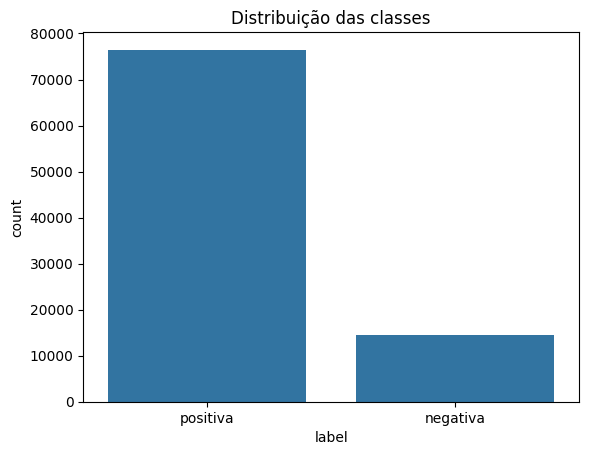

,len_chars
label,
negativa,54.328851
positiva,14.963829


In [60]:
# ===============================
# 6. EDA rápida
# ===============================
# Distribuição de classes
sns.countplot(x='label', data=df)
plt.title('Distribuição das classes')
plt.show()

# Comprimento médio das reviews por classe
df['len_chars'] = df['text_clean'].apply(len)
df.groupby('label')['len_chars'].mean()


In [61]:
# ===============================
# 7. Preparar dados para ML
# ===============================
X = df['text_clean']
y = df['label_bin']  # binário 0/1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [62]:
# ===============================
# 8. Pipeline e GridSearch
# ===============================
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

params = {
    'tfidf__max_features': [5000, 10000, 20000],
    'clf__C': [0.1, 1.0, 5.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(pipeline, params, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print('Melhores parâmetros:', gs.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Melhores parâmetros: {'clf__C': 5.0, 'tfidf__max_features': 20000}


              precision    recall  f1-score   support

    negativa       0.79      0.71      0.74      2915
    positiva       0.95      0.96      0.95     15294

    accuracy                           0.92     18209
   macro avg       0.87      0.84      0.85     18209
weighted avg       0.92      0.92      0.92     18209



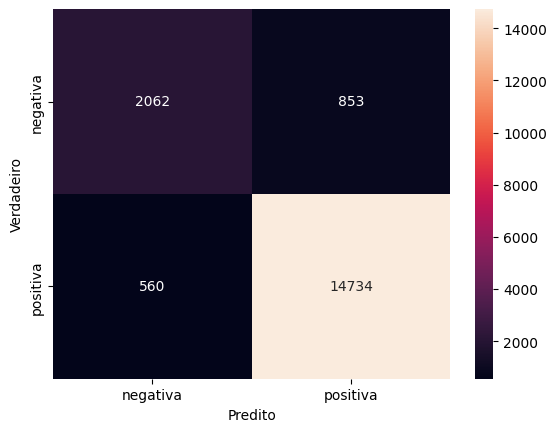

In [63]:
# ===============================
# 9. Avaliação do modelo
# ===============================
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['negativa','positiva']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['negativa','positiva'], yticklabels=['negativa','positiva'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()


In [64]:
# ===============================
# 10. Salvar modelo
# ===============================
import joblib
joblib.dump(gs.best_estimator_, 'model_review_clf.joblib')
print("Modelo salvo como model_review_clf.joblib")


Modelo salvo como model_review_clf.joblib


In [65]:
vec = gs.best_estimator_.named_steps['tfidf']
clf = gs.best_estimator_.named_steps['clf']
feature_names = vec.get_feature_names_out()
coefs = clf.coef_[0]

top_pos = np.argsort(coefs)[-20:]
top_neg = np.argsort(coefs)[:20]

print('Top palavras positivas:', feature_names[top_pos])
print('Top palavras negativas:', feature_names[top_neg])

Top palavras positivas: ['nenhum problema' 'ótima' 'bem' 'exatamente' 'antes' 'rapir' 'direitinho'
 'amei' 'ótimo' 'conforme' 'recomendo' 'em prazo' 'certinho' 'adorar'
 'antes de' 'ameir' 'parabéns' 'lir' 'perfeito' 'rápido']
Top palavras negativas: ['péssimo' 'insatisfeito' 'lindo entrega' 'comprei' 'nao' 'cancelar'
 'passar' 'entregar' 'inferior' 'recebi' 'pessimo' 'ruim' 'prazo porém'
 'aguardar' 'rápido parabéns' 'vir' 'falsificar' 'resposta' 'funcionar'
 'bom tarde']
